##### Libraries

In [1]:
from datasets import load_dataset,Dataset
from datasets.features import Features,Value
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pylab as plt
import os

In [2]:
sns.set(rc={'figure.figsize':(18.7,11.27)})
pd.set_option('display.float_format', lambda x: '%.3f' % x)

##### Data Understanding

In [3]:
data_path = os.getenv("NEWS_DATA_PATH")

In [4]:
!head -c 300 $data_path

,Unnamed: 0,date,year,month,day,author,title,article,url,section,publication
0,0,2016-12-09 18:31:00,2016,12.0,9,Lee Drutman,We should take concerns about the health of liberal democracy seriously,"This post is part of Polyarchy, an independent blog produced by the political reform program at New Am

In [5]:
!tail -c 500 $data_path

ously known for getting her sweat on. Stephen Colbert documented his attempt to keep up with her recently, and it was pretty hilarious ... she was kinda out of his league and in her own world when it comes to fitness. On another note ... it sounds like she's still working when it comes to SCOTUS biz too. Law360 notes she calls into conference chats via phone with the other robes these days.",https://www.tmz.com/2020/04/01/ruth-bader-ginsburg-rbg-justice-working-out-gym-trainer-coronavirus/,,TMZ


The columns have to be change for a more readable names

In [6]:
columns = ["idx","article_idx","date","year","month","day","author","title","article","url","section","publication"]

In [7]:
features_dict = Features({i: Value("int16")  if i in ["idx","article_idx"] else Value("string") for i in columns})

In [8]:
features_dict

{'idx': Value(dtype='int16', id=None),
 'article_idx': Value(dtype='int16', id=None),
 'date': Value(dtype='string', id=None),
 'year': Value(dtype='string', id=None),
 'month': Value(dtype='string', id=None),
 'day': Value(dtype='string', id=None),
 'author': Value(dtype='string', id=None),
 'title': Value(dtype='string', id=None),
 'article': Value(dtype='string', id=None),
 'url': Value(dtype='string', id=None),
 'section': Value(dtype='string', id=None),
 'publication': Value(dtype='string', id=None)}

In [20]:
df = load_dataset("csv",data_files=[data_path],skiprows=[0,2_324_812],column_names=columns,features=features_dict)

Using custom data configuration default-743872de51535b2e
Reusing dataset csv (/home/rjac/.cache/huggingface/datasets/csv/default-743872de51535b2e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

##### Data Exploration

##### Dataset

The datasets consist of News with metada about the author,dates,title, url and the publisher. the article will be use as the main corpus.

In [22]:
df["train"][0:3]

{'idx': [0, 1, 2],
 'article_idx': [0, 1, 2],
 'date': ['2016-12-09 18:31:00', '2016-10-07 21:26:46', '2018-01-26 00:00:00'],
 'year': ['2016', '2016', '2018'],
 'month': ['12.0', '10.0', '1.0'],
 'day': ['9', '7', '26'],
 'author': ['Lee Drutman', 'Scott Davis', None],
 'title': ['We should take concerns about the health of liberal democracy seriously',
  "Colts GM Ryan Grigson says Andrew Luck's contract makes it difficult to build the team",
  'Trump denies report he ordered Mueller fired'],
 'article': ['This post is part of Polyarchy, an independent blog produced by the political reform program at New America, a Washington think tank devoted to developing new ideas and new voices. Imagine you are an otherwise healthy 30-something who starts feeling weird. You are sometimes short of breath. You get migraines. Your feet start to swell a little. But otherwise, everything seems fine. You go to the doctor. The doctor runs some tests. She tells you,\xa0It\'s probably nothing, but these 

##### Nuber of articles per date

In [25]:
def string_to_datetime(batch):
    """
    Transform string date into a datetime object. it truncates any date into 10 character string 
    assuming a date format of yyyy-mm-dd (Batch function).

    Args:
        batch (datasets.Dataset): batch dataset of the main information 
    Returns:
        result (Dict[datetime:list]): Dictionary with list of datetime object
    """
    dates = batch["date"]
    dates = [date[0:10] for date in dates]
    dates = [datetime.strptime(date,'%Y-%m-%d') for date in dates]
    return {"datetime":dates}

In [27]:
df = df.map(string_to_datetime,batched=True,num_proc=10)

#2:   0%|          | 0/269 [00:00<?, ?ba/s]

#1:   0%|          | 0/269 [00:00<?, ?ba/s]

#0:   0%|          | 0/269 [00:00<?, ?ba/s]

#3:   0%|          | 0/269 [00:00<?, ?ba/s]

#4:   0%|          | 0/269 [00:00<?, ?ba/s]

#5:   0%|          | 0/269 [00:00<?, ?ba/s]

#6:   0%|          | 0/269 [00:00<?, ?ba/s]

#7:   0%|          | 0/269 [00:00<?, ?ba/s]

#8:   0%|          | 0/269 [00:00<?, ?ba/s]

#9:   0%|          | 0/269 [00:00<?, ?ba/s]

<AxesSubplot:ylabel='count'>

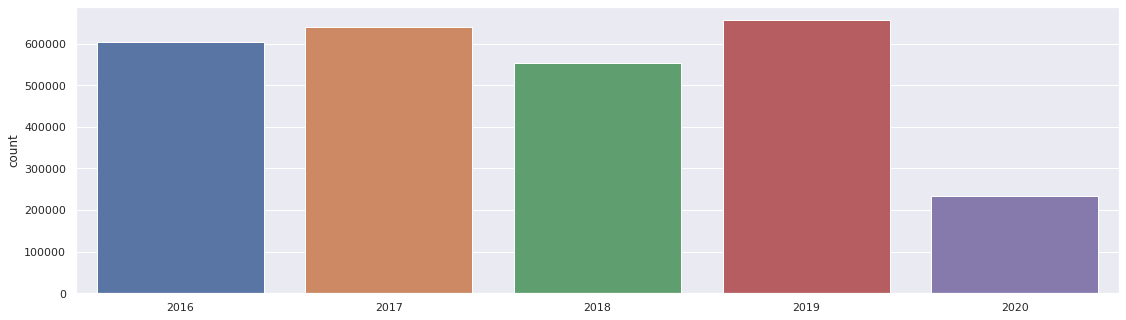

In [28]:
sns.set(rc={'figure.figsize':(18.7,5.27)})
sns.countplot(x=[d.year for d in df["train"]["datetime"]])

In [30]:
dates_of_articles = pd.DataFrame({"dates":df["train"]["datetime"]})

In [40]:
dates_of_articles["year"] = dates_of_articles.dates.dt.year
dates_of_articles["months"] = dates_of_articles.dates.dt.month

In [50]:
months_per_year = dates_of_articles.groupby(["year","months"]).count().unstack()
months_per_year.columns = [1,2,3,4,5,6,7,8,9,110,11,12]

<AxesSubplot:ylabel='year'>

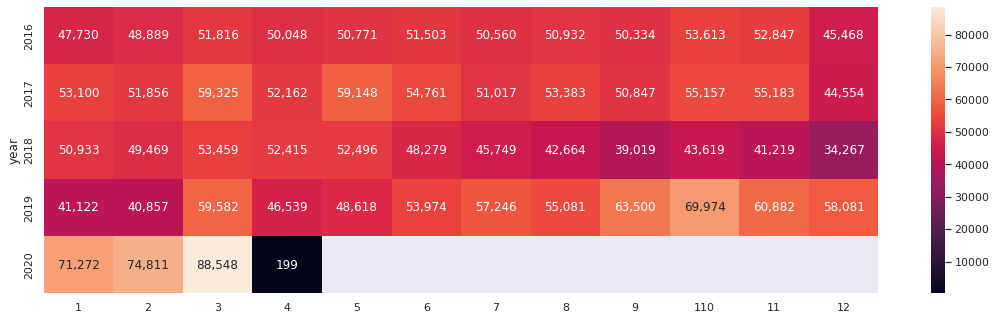

In [59]:
sns.heatmap(months_per_year,annot=True,fmt=",.0f")

### News longer sequence

In [60]:
def get_and_count_tokens(batch):
    """
    Split the article text into tokens and count the number of it (Batch function).

    Args:
        batch (datasets.Dataset): batch dataset of the main information 
    Returns:
        result (Dict[tokens:list,article_len:list]): Dictionary with number of token per article and the corresponding tokens
    """
    articles = batch["article"]
    articles_tokens = [[] if article == None else article.split() for article in articles]
    len_articles_token = [len(tokens) for tokens in articles_tokens ]
    result = {"tokens":articles_tokens,"article_len":len_articles_token}
    return result

In [61]:
df = df.map(get_and_count_tokens,batched=True,num_proc=10)

#0:   0%|          | 0/269 [00:00<?, ?ba/s]

#1:   0%|          | 0/269 [00:00<?, ?ba/s]

#4:   0%|          | 0/269 [00:00<?, ?ba/s]

#3:   0%|          | 0/269 [00:00<?, ?ba/s]

#2:   0%|          | 0/269 [00:00<?, ?ba/s]

#5:   0%|          | 0/269 [00:00<?, ?ba/s]

#6:   0%|          | 0/269 [00:00<?, ?ba/s]

#7:   0%|          | 0/269 [00:00<?, ?ba/s]

#8:   0%|          | 0/269 [00:00<?, ?ba/s]

#9:   0%|          | 0/269 [00:00<?, ?ba/s]

<AxesSubplot:ylabel='Count'>

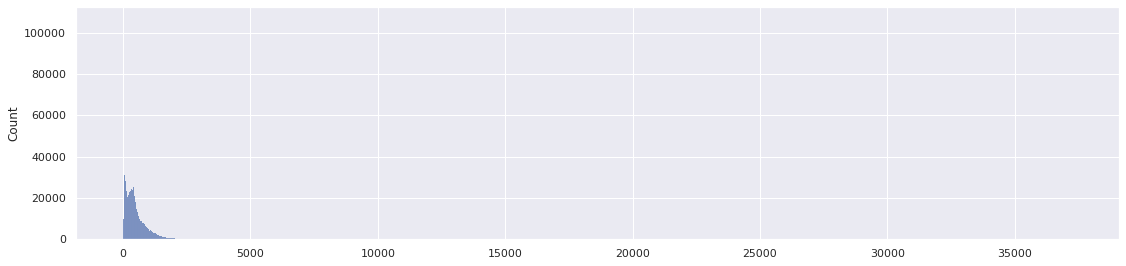

In [62]:
sns.set(rc={'figure.figsize':(18.7,4.27)})
sns.histplot(x=df["train"]["article_len"]) 

If we remove outliers (base on Boxplot Interquartile range) , we can visualize that every Article could contain from 200 to 650 words. We have news without article and longer News thatvary from 800 to 1,400 words. considering the max value is 37k words 

<AxesSubplot:>

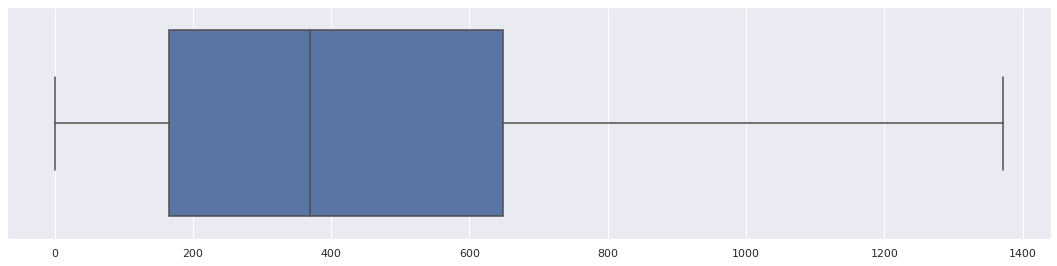

In [27]:
sns.set(rc={'figure.figsize':(18.7,4.27)})
sns.boxplot(x=df["train"]["article_len"],showfliers = False) 


In [30]:
pd.DataFrame({"len":df["train"]["article_len"]}).describe().T

,count,mean,std,min,25%,50%,75%,max
len,2688878.000,495.779,566.953,0.000,165.000,370.000,648.000,37240.000


##### Publication site

<AxesSubplot:ylabel='count'>

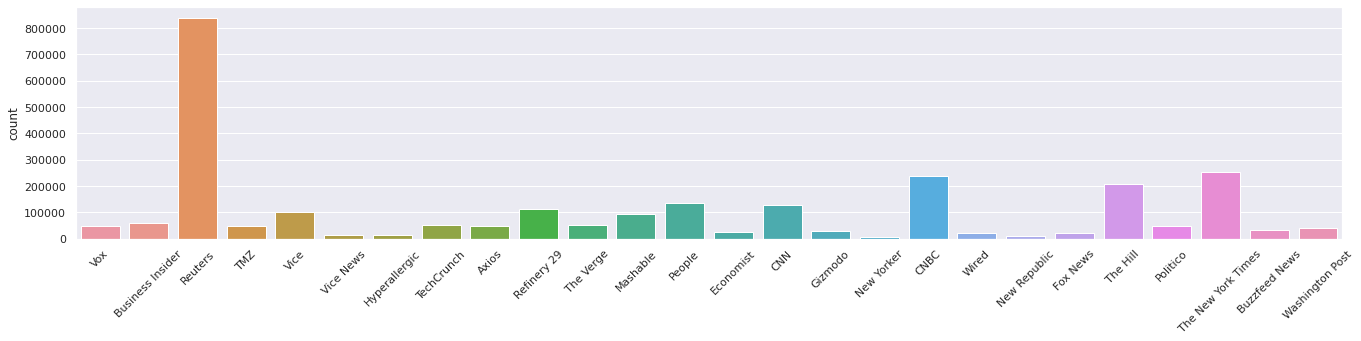

In [37]:
sns.set(rc={'figure.figsize':(22.7,4.27)})
plt.xticks(rotation=45)
sns.countplot(x=df["train"]["publication"])